In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.utils import *
from esa.lstm_utils import *

import platform

import numpy as np

architecture = 'lstm_ae'

In [5]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_ae_sl_16_emb_64_layers_1_1_22_03_2023_11:26:31.pth


In [6]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_ae_sl_16_emb_64_layers_1_1_22_03_2023_11:26:31.pth


In [7]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [8]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model],
                        map_location=device)
params_conf = checkpoint['param_conf']

In [11]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
    
out_window = params_conf['out_window']

latent_dim = params_conf['latent_dim']
seq_len = params_conf['sequence_length']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
try:
    no_latent = params_conf['no_latent']
except:
    no_latent = False
shuffle = False

data_path = params_conf['data_path']

In [12]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [16]:
model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=len(params_conf['target']),
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']
                , no_latent = no_latent)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, batch_first=True)
    (enc): Linear(in_features=64, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(100, 64, batch_first=True)
    (LSTM1): LSTM(64, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=16, bias=True)
  )
)
number of params 274804


In [18]:
compute_mse_val_loss = False

In [19]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [23]:
num_batch = 10
inject_anomalies = False

if inject_anomalies:
    x, shift = unrolling_batches_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=sequence_length, cols=cols, shift = None)
else:
    x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 25678


In [24]:
x, enc, yo = model(x.to(device))
if inject_anomalies:
    xa, enc, ya = model(xa.to(device))
save = False

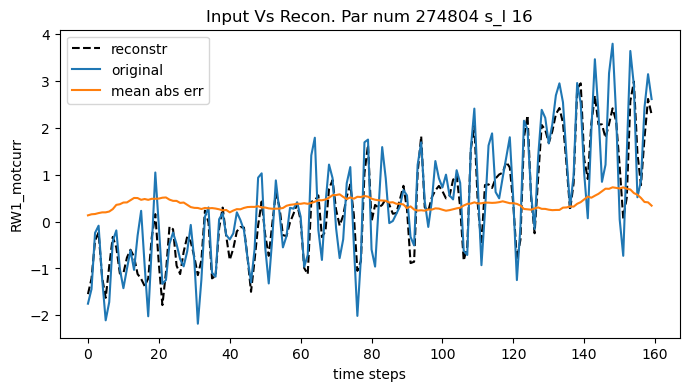

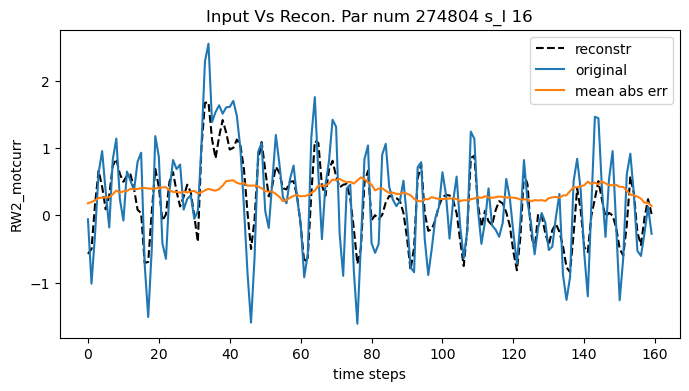

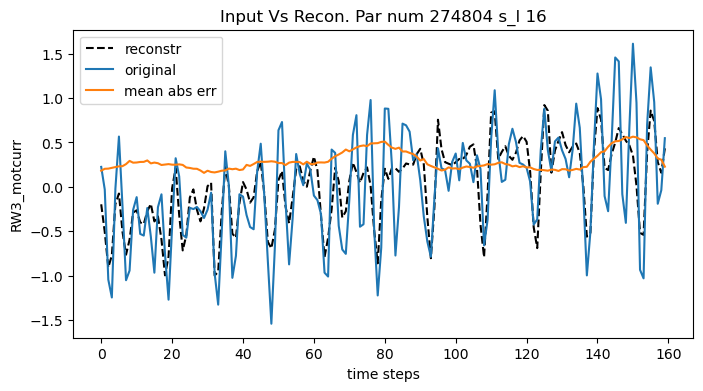

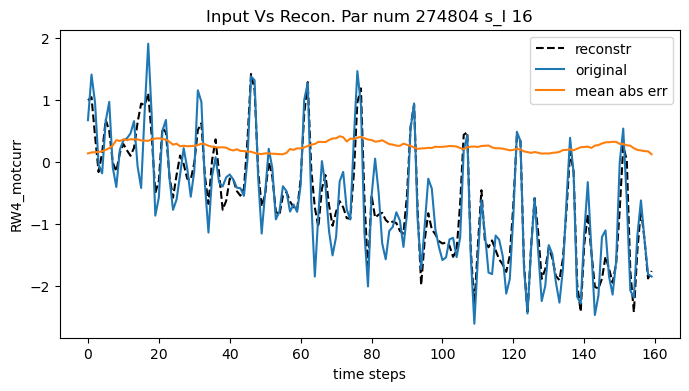

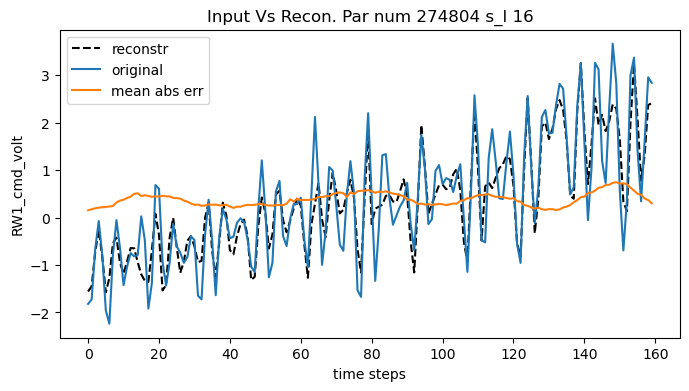

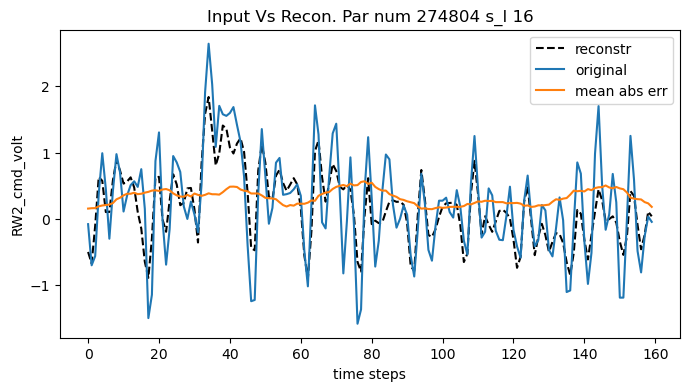

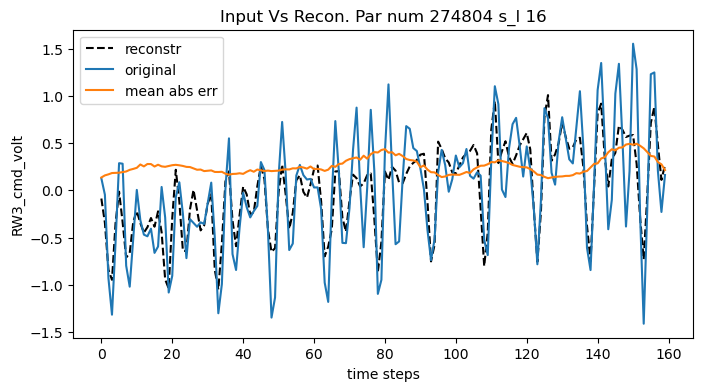

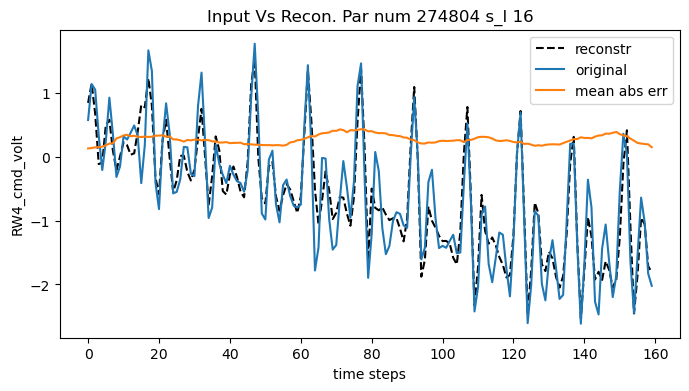

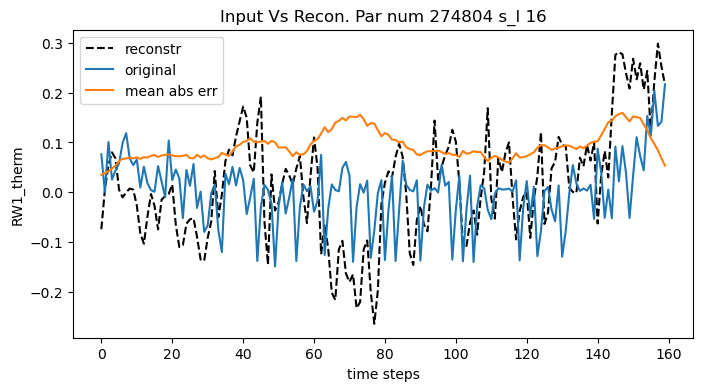

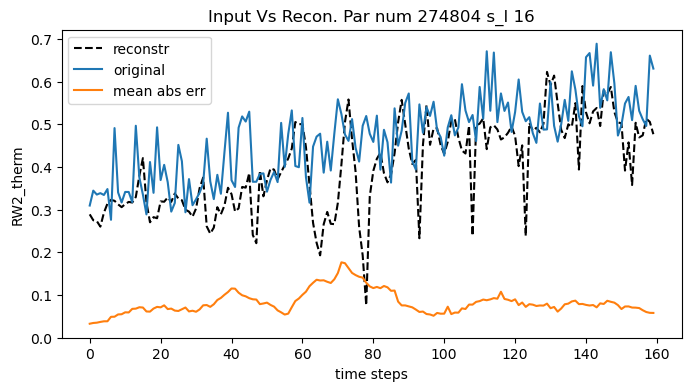

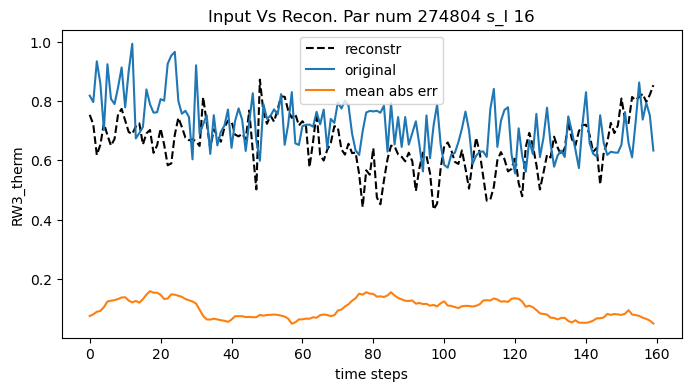

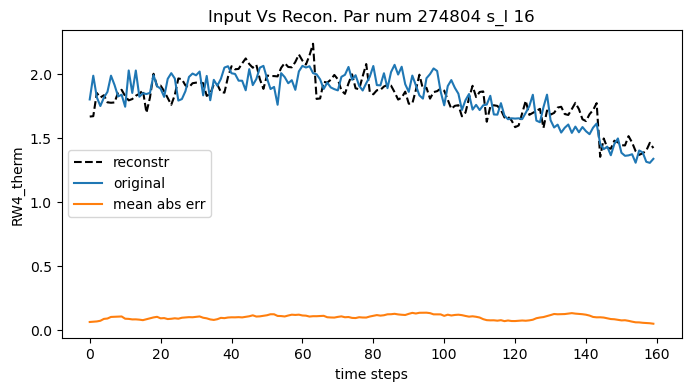

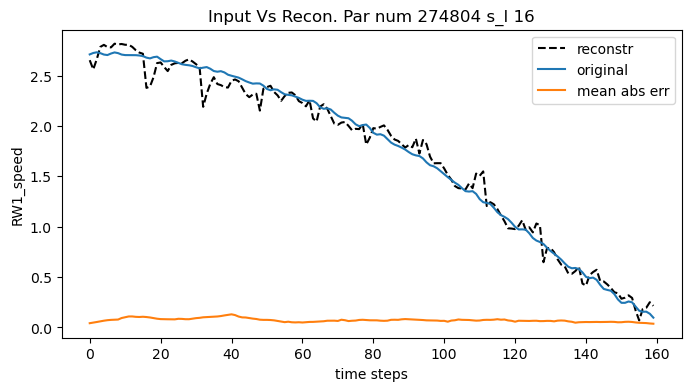

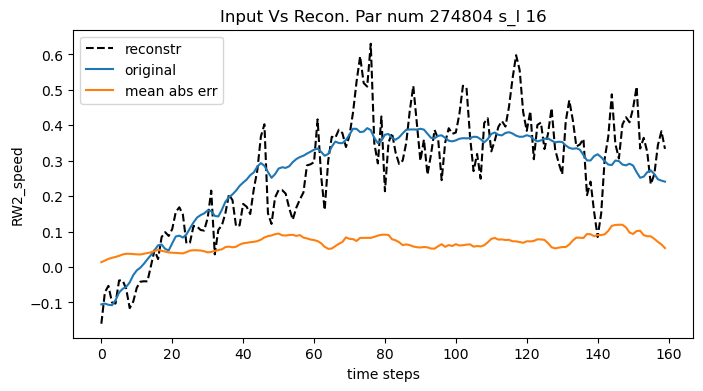

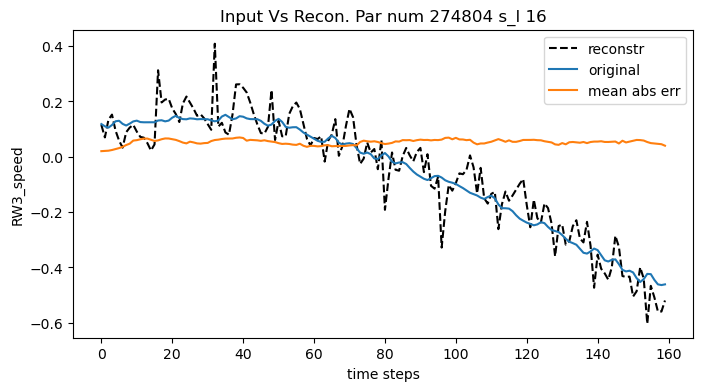

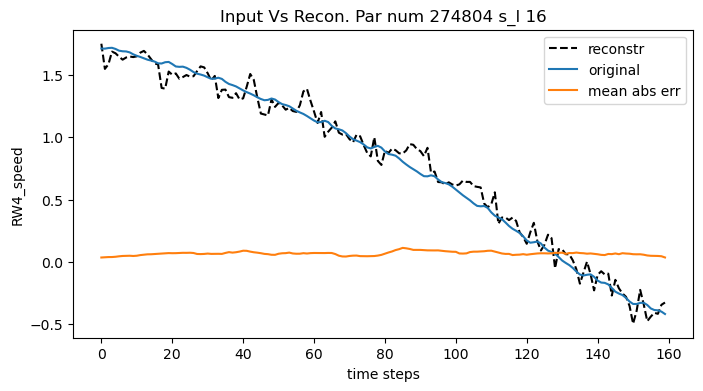

In [25]:
show_results(x, yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,architecture=architecture,save=False)